In [194]:
import sys

import numpy as np

from enum import IntEnum, unique, auto

from matplotlib import pyplot as plt, patches

In [195]:
@unique
class Direction(IntEnum):
    NONE  = -1
    LEFT  = 0
    RIGHT = 1
    UP    = 2
    DOWN  = 3
    def __str__(self) :
        return self.name[0]
    def as_coordinates(self) :
        if self.value == 0 : return (-1, 0)
        if self.value == 1 : return ( 1, 0)
        if self.value == 2 : return ( 0, 1)
        if self.value == 3 : return ( 0,-1)
        raise NotImplementedError(f"No coordinate implemented for Direction {self.name}")
    
all_directions = [d for d in Direction if d != Direction.NONE]

def get_greedy_action(q, s, epsilon=0, verbose=False) :
    if (epsilon<0) or (epsilon>1) :
        raise ValueError(f"Epsilon with value {epsilon:.3f} (must be 0 <= epsilon <= 1)")
    current_x, current_y = s[0], s[1]
    possible_actions     = []
    best_actions, best_action_value = [(0,0)], -np.inf
    for possible_action in all_directions :
        add_x, add_y = possible_action.as_coordinates()
        new_x, new_y = current_x + add_x, current_y + add_y
        if (new_x < 0) or (new_x > 9) : continue
        if (new_y < 0) or (new_y > 9) : continue
        if new_y==0 and new_x!=0 and new_x!=9 : new_x, new_y = 0, 0
        possible_actions.append((add_x, add_y))
        new_action_value = q.get((current_x, current_y, add_x, add_y), 0.)
        if new_action_value < best_action_value : continue
        if new_action_value == best_action_value : best_actions.append((add_x, add_y))
        else : best_actions, best_action_value = [(add_x, add_y)], new_action_value
    num_possible_actions, num_best_actions = len(possible_actions), len(best_actions)
    probs = [(1 - epsilon)/num_best_actions + epsilon/num_possible_actions if a in best_actions else epsilon/num_possible_actions for a in possible_actions]
    if verbose : print(f"State {s} with possible actions {possible_actions} (probs are {[f'{p:.3f}' for p in probs]})")
    return possible_actions[np.random.choice(len(possible_actions), p=probs)]
    
def get_action_and_next_reward_and_state(q, s, epsilon, verbose=False) :
    a            = get_greedy_action(q, s, epsilon, verbose=verbose)
    new_x, new_y = s[0] + a[0], s[1] + a[1]
    reward       = -1.
    if new_y==0 and new_x!=0 and new_x!=9 :
        reward = -100.
        new_x, new_y = 0, 0
    new_s = (new_x, new_y)
    if verbose : print(f"Action {a} with reward {reward} and new state {new_s}")
    return a, reward, new_s

def is_terminal_state(s) :
    return s == (9, 0)

def is_cliff(s) :
    return s[1]==0 and s[0]!=0 and s[0]!=9

def update_state(s, a) :
    if type(a) == Direction : a = a.as_coordinates()
    new_x, new_y = s[0] + a[0], s[1] + a[1]
    if new_y==0 and new_x!=0 and new_x!=9 : new_x, new_y = 0, 0
    return (new_x, new_y)

def is_allowed_action(s, a) :
    if type(a) == Direction : a = a.as_coordinates()
    new_x, new_y = s[0] + a[0], s[1] + a[1]
    if (new_x < 0) or (new_x > 9) : return False
    if (new_y < 0) or (new_y > 9) : return False
    return True

def run_episode_SARSA(q, epsilon, alpha_omega, gamma, verbose=False) :
    st = (0, 0)
    at, rtp, stp = get_action_and_next_reward_and_state(q, st, epsilon)
    t, states_visited = 1, [st, stp]
    while not is_terminal_state(stp) :
        atp, rtpp, stpp = get_action_and_next_reward_and_state(q, stp, epsilon, verbose=verbose)
        q_sa   = q.get((st [0], st [1], at [0], at [1]), 0.)
        q_spap = q.get((stp[0], stp[1], atp[0], atp[1]), 0.)
        q[(st[0], st[1], at[0], at[1])] = q_sa + (rtp + gamma*q_spap - q_sa) / (t**alpha_omega)
        st, at, rtp, stp = stp, atp, rtpp, stpp
        states_visited.append(stp)
        t += 1
    return states_visited

def run_episode_Q(q, epsilon, alpha_omega, gamma, verbose=False) :
    st = (0, 0)
    at, rtp, stp = get_action_and_next_reward_and_state(q, st, epsilon)
    t, states_visited = 1, [st, stp]
    while not is_terminal_state(stp) :
        atp, rtpp, stpp = get_action_and_next_reward_and_state(q, stp, epsilon, verbose=verbose)
        atp_Qlearn      = get_greedy_action(q, stp, epsilon=0)
        q_sa   = q.get((st [0], st [1], at        [0], at        [1]), 0.)
        q_spap = q.get((stp[0], stp[1], atp_Qlearn[0], atp_Qlearn[1]), 0.)
        q[(st[0], st[1], at[0], at[1])] = q_sa + (rtp + gamma*q_spap - q_sa) / (t**alpha_omega)
        st, at, rtp, stp = stp, atp, rtpp, stpp
        states_visited.append(stp)
        t += 1
    return states_visited

def run_episode_doubleQ(q1, q2, epsilon, alpha_omega, gamma, verbose=False) :
    st = (0, 0)
    at, rtp, stp = get_action_and_next_reward_and_state(q1, st, epsilon)
    t, states_visited = 1, [st, stp]
    while not is_terminal_state(stp) :
        q_update, q_eval = q1, q2
        if t % 2 == 0 : q_update, q_eval = q2, q1
        atp, rtpp, stpp = get_action_and_next_reward_and_state(q_update, stp, epsilon, verbose=verbose)
        atp_Qlearn      = get_greedy_action(q_update, stp, epsilon=0)
        q_sa   = q_update.get((st [0], st [1], at        [0], at        [1]), 0.)
        q_spap = q_eval  .get((stp[0], stp[1], atp_Qlearn[0], atp_Qlearn[1]), 0.)
        q_update[(st[0], st[1], at[0], at[1])] = q_sa + (rtp + gamma*q_spap - q_sa) / (t**alpha_omega)
        st, at, rtp, stp = stp, atp, rtpp, stpp
        states_visited.append(stp)
        t += 1
    return states_visited
        

In [196]:

def plot_last_episode(q, episode_states, label="") :
    if type(q) is list :
        keys = []
        for qs in q :
            for k in qs :
                if k in keys : continue
                keys.append(k)
        new_q = {}
        for k in keys :
            new_q[k] = np.mean([qs.get(k,0.) for qs in q])
        q = new_q
        
    fig = plt.figure(figsize=(12, 6))
    ax  = fig.add_subplot(121)
    ax.set_xlim([-0.5, 9.5])
    ax.set_ylim([-0.5, 9.5])

    for state_pair in zip(episode_states[:-1], episode_states[1:]) :
        x1, y1, x2, y2 = state_pair[0][0], state_pair[0][1], state_pair[1][0], state_pair[1][1]
        ax.arrow(x1, y1, x2-x1, y2-y1, color="blue", alpha=0.3)

    for x in np.arange(0, 10) :
        for y in np.arange(0, 10) :
            if is_cliff((x, y)) :
                rect = patches.Rectangle((x-0.5, y-0.5), 1, 1, linewidth=1, facecolor='lightgray', alpha=0.7)
                ax.add_patch(rect)
                continue
            rect = patches.Rectangle((x-0.5, y-0.5), 1, 1, linewidth=1, edgecolor='lightgray', facecolor='none')
            ax.add_patch(rect)
            actions = [d.as_coordinates() for d in all_directions]
            value   = np.min([q.get((x, y, a[0], a[1]), 0.) for a in actions])
            ax.text(x, y, f"{value:.1f}", ha="center", va="center")

    ax.text(4.5, 0, f"CLIFF", ha="center", va="center", weight="bold")
    ax.set_title(r"min $q(s,a)$ and path taken " + f"({label})", weight="bold", fontsize=15)
    ax.xaxis.set_ticks([])
    ax.yaxis.set_ticks([])

    ax  = fig.add_subplot(122)
    ax.set_xlim([-0.5, 9.5])
    ax.set_ylim([-0.5, 9.5])

    visited_states, old_state, new_state = [], (0, 0), None
    while not is_terminal_state(old_state) and old_state not in visited_states :
        visited_states.append(old_state)
        action = get_greedy_action(q, old_state, epsilon=0)
        new_state = update_state(old_state, action)
        ax.arrow(old_state[0], old_state[1], new_state[0]-old_state[0], new_state[1]-old_state[1], color="red", alpha=0.5)
        old_state = new_state

    for x in np.arange(0, 10) :
        for y in np.arange(0, 10) :
            if is_cliff((x, y)) :
                rect = patches.Rectangle((x-0.5, y-0.5), 1, 1, linewidth=1, facecolor='lightgray', alpha=0.7)
                ax.add_patch(rect)
                continue
            rect = patches.Rectangle((x-0.5, y-0.5), 1, 1, linewidth=1, edgecolor='lightgray', facecolor='none')
            ax.add_patch(rect)
            actions = [d.as_coordinates() for d in all_directions if is_allowed_action((x,y), d)]
            value   = np.max([q.get((x, y, a[0], a[1]), 0.) for a in actions])
            ax.text(x, y, f"{value:.1f}", ha="center", va="center")

    ax.text(4.5, 0, f"CLIFF", ha="center", va="center", weight="bold")
    ax.set_title(r"max $q(s,a)$ and greedy policy " + f"({label})", weight="bold", fontsize=15)
    ax.xaxis.set_ticks([])
    ax.yaxis.set_ticks([])

    plt.show()

=====   1 EPISODES COMPLETE   =====

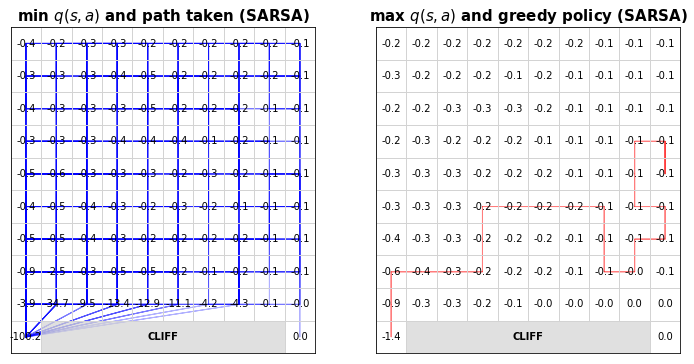

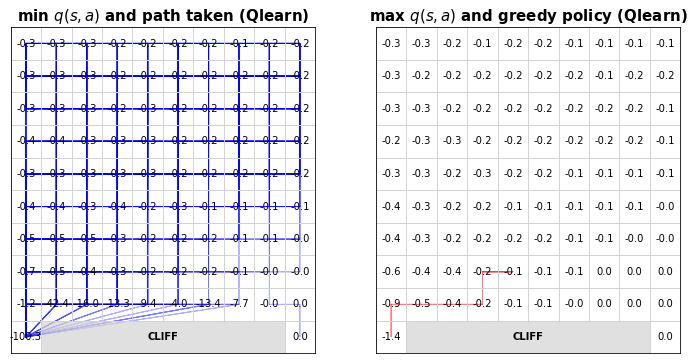

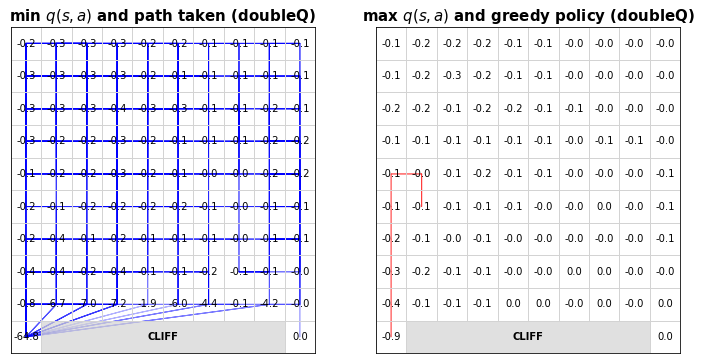

=====   10 EPISODES COMPLETE   =====

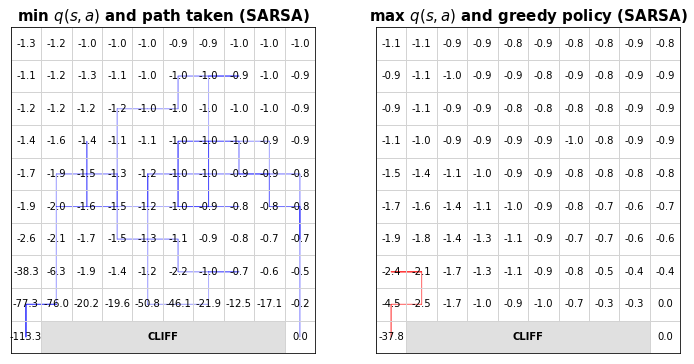

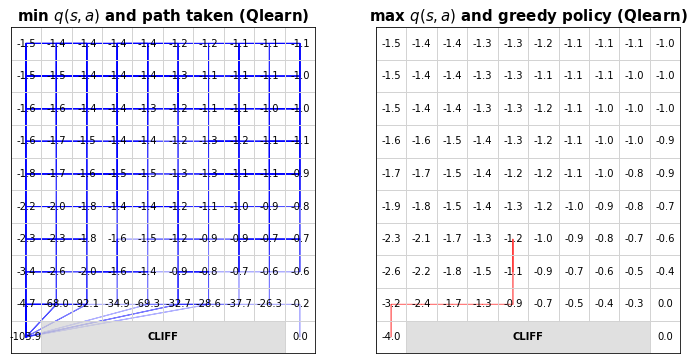

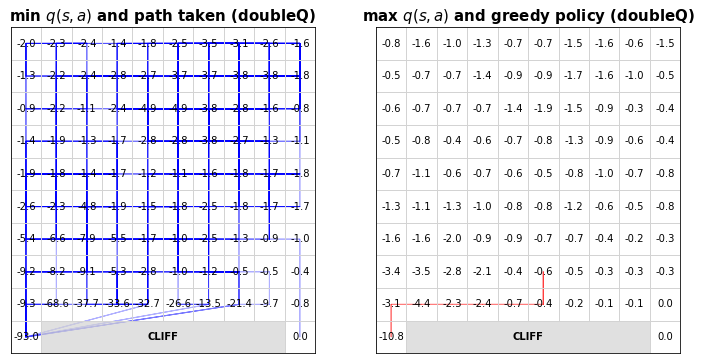

=====   50 EPISODES COMPLETE   =====

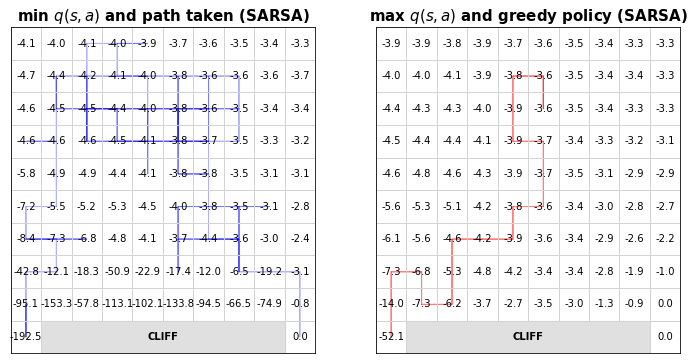

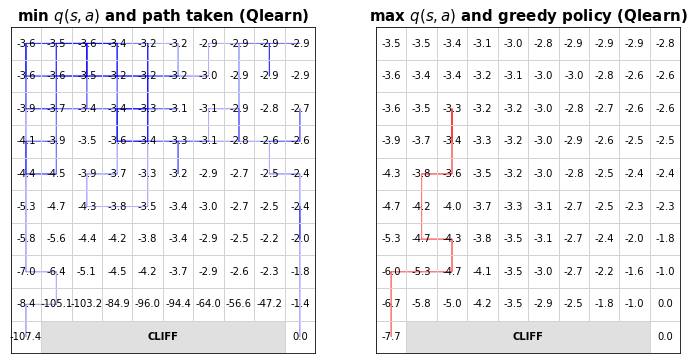

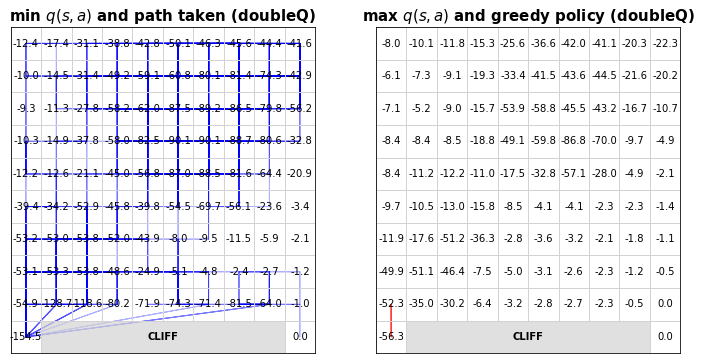

=====   200 EPISODES COMPLETE   =====

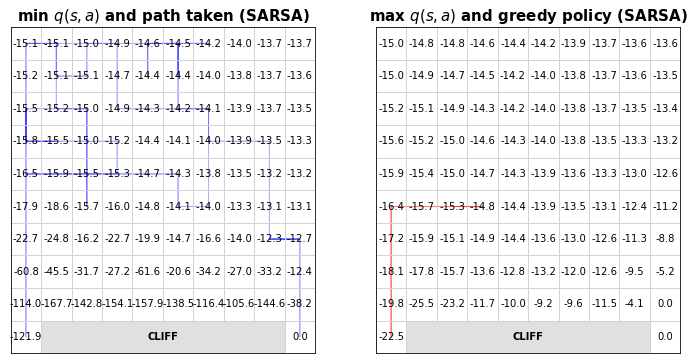

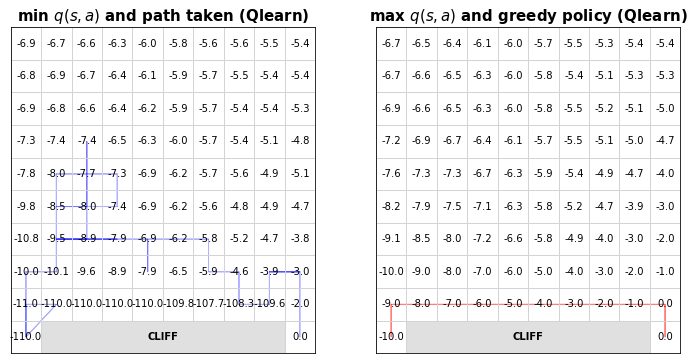

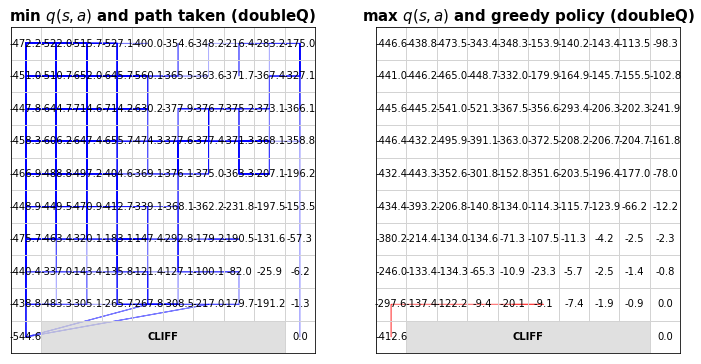

=====   1000 EPISODES COMPLETE   =====

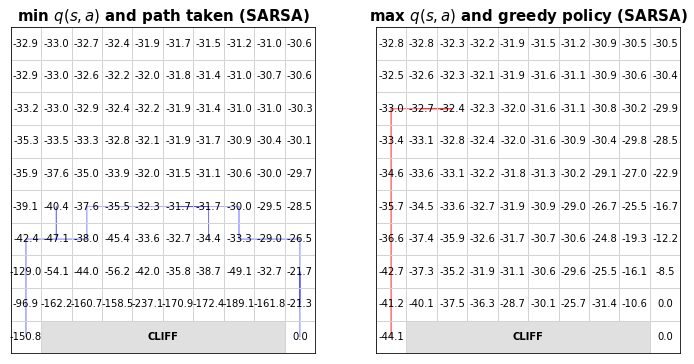

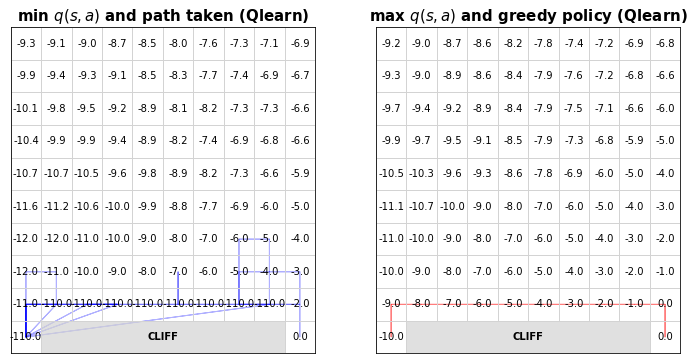

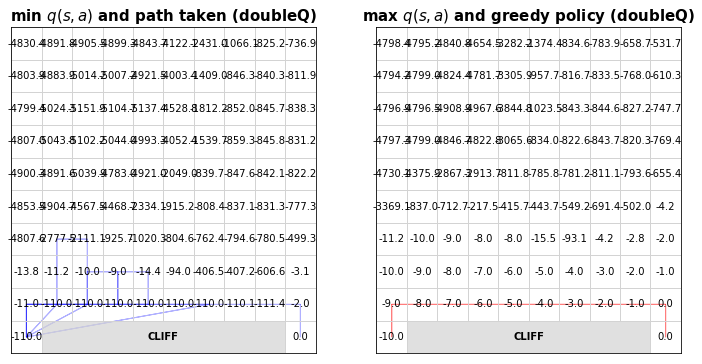

=====   10000 EPISODES COMPLETE   =====

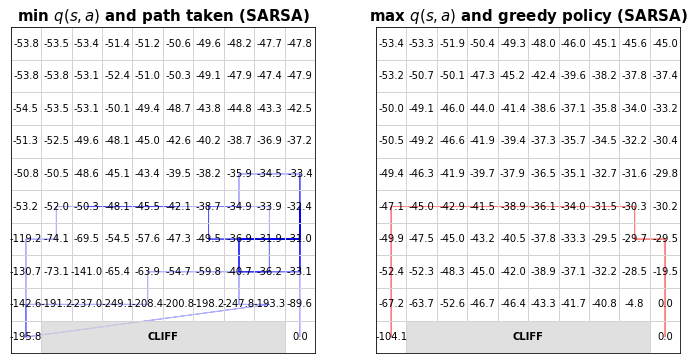

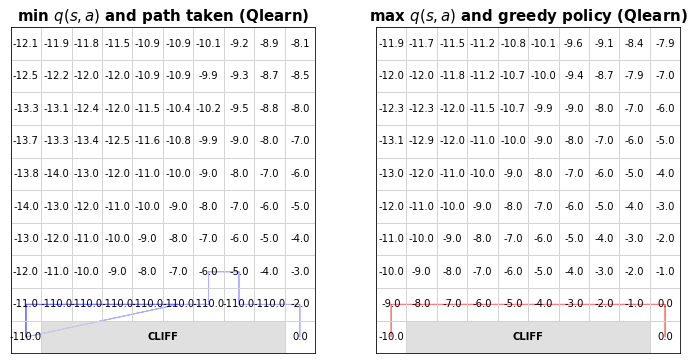

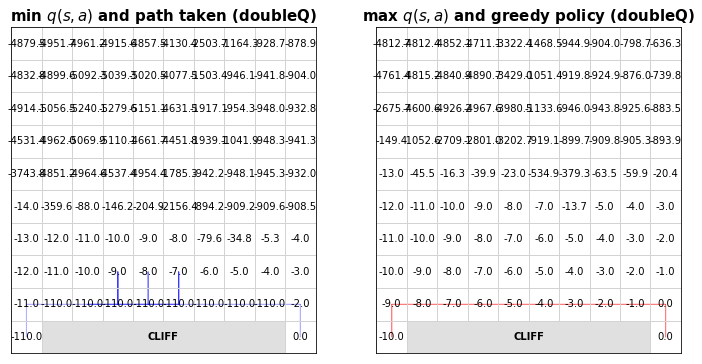

=====   100000 EPISODES COMPLETE   =====

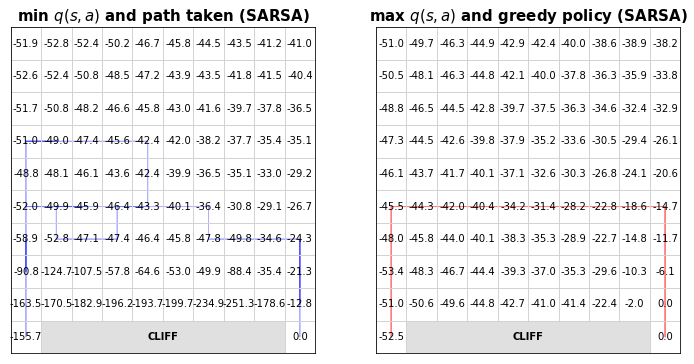

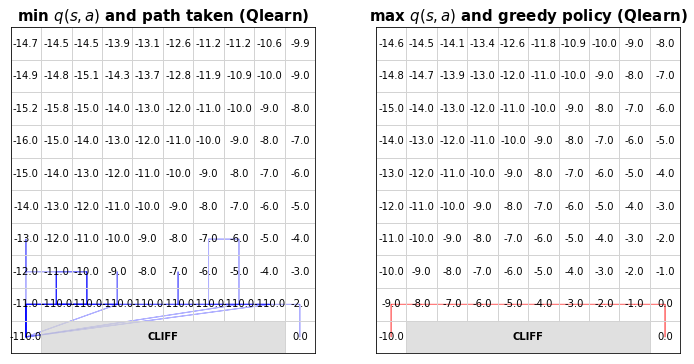

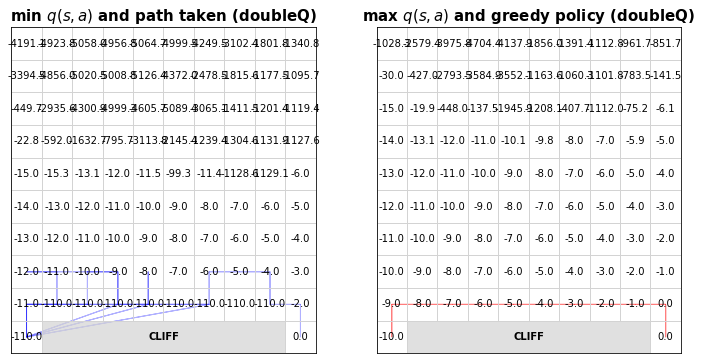

In [200]:
epsilon     = 0.5
alpha_omega = 0.5
gamma       = 1

num_episodes     = 100000
episodes_to_plot = [1, 10, 50, 200, 1000, 10000, 100000]

q_SARSA, q_Qlearn = {}, {}
q_doubleQ1, q_doubleQ2 = {}, {}
for ep_idx in range(num_episodes) :
    SARSA_episode_states   = run_episode_SARSA  (q_SARSA , epsilon, alpha_omega, gamma)
    Qlearn_episode_states  = run_episode_Q      (q_Qlearn, epsilon, alpha_omega, gamma)
    doubleQ_episode_states = run_episode_doubleQ(q_doubleQ1, q_doubleQ2, epsilon, alpha_omega, gamma)
    sys.stdout.write(f"\r=====   {ep_idx+1} EPISODES COMPLETE   =====")
    #sys.stdout.flush()
    if ep_idx+1 not in episodes_to_plot : continue
    plot_last_episode(q_SARSA , SARSA_episode_states , label="SARSA")
    plot_last_episode(q_Qlearn, Qlearn_episode_states, label="Qlearn")
    plot_last_episode([q_doubleQ1, q_doubleQ2], doubleQ_episode_states, label="doubleQ")